Author: Judit Lozano Gondolbeu

### Libraries

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
                             classification_report,  accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones

In [2]:
def dame_curvas(modelo):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=90)
    model = modelo
        
    # predecimos probabilidades
    prob_predictions = model.predict_proba(X_test)
    # mantener las probabilidades para resultados positivos solamente
    yhat = prob_predictions[:, 1]
    fpr, tpr, thresholds = roc_curve([elem == 1 for elem in y_test], yhat)
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)

    # graficamos la curva roc del modelo
    ax1.plot([0,1], [0,1], linestyle='--', label='No Skill')
    ax1.plot(fpr, tpr, marker='.', label=str(model)[:10])
    ax1.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
    # axis labels
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(str(model)[:10]+ ' - Best Threshold=%f, G-Mean=%.3f'% (thresholds[ix], gmeans[ix]))
    ax1.legend()
    
     #calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_test, yhat)
    
    
    # plot the pr- curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    ax2.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
    ax2.plot(recall, precision, marker='.', label=str(model)[:10]) 
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    
    # show the plot
    plt.tight_layout() 
    
    f, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 5), dpi=90)
    #graficamos la curva de ganancia
    skplt.metrics.plot_cumulative_gain(y_test, prob_predictions, ax=ax3) 
    ax3.set_title(str(model)[:10]+" - Cumulative Gains curve")
    
     # graficamos la curva lift
    skplt.metrics.plot_lift_curve(y_test, prob_predictions, ax=ax4) 
    ax4.set_title(str(model)[:10]+" - Lift_curve")
    
    
    # show the plot
    plt.tight_layout()
    
    

def dame_matrices(modelo_entrenado):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    model = modelo_entrenado
    cm = confusion_matrix(y_test, y_pred=model.predict(X_test).astype(int), normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(cmap='Blues', ax=ax1)
    disp.ax_.set_title((str(model)[:10]+" - Confusion matrix, without normalization"))

    cm2 = confusion_matrix(y_test, y_pred=model.predict(X_test).astype(int), normalize='true')
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(cmap='Blues', ax=ax2)
    disp2.ax_.set_title((str(model)[:10]+" - Normalized confusion matrix"))
    
    
    plt.tight_layout() 
    
    
def matrices_threshold(modelo_entrenado):
    model = modelo_entrenado
    # predecimos probabilidades
    predict_p = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, predict_p)
    gmeans = np.sqrt(tpr*(1-fpr))
    index = np.argmax(gmeans)
    #predictions and optimal thresholds
    y_pred = np.where(predict_p>thresholds[index], 1 ,0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    cm = confusion_matrix(y_test, y_pred=y_pred, normalize=None)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(cmap='Blues', ax=ax1)
    disp.ax_.set_title("Applicando threshold \n " + str(model)[:10]+" - Confusion matrix, without normalization")

    cm2 = confusion_matrix(y_test, y_pred=y_pred, normalize='true')
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
    disp2.plot(cmap='Blues', ax=ax2)
    disp2.ax_.set_title("Applicando threshold \n " + str(model)[:10]+" - Normalized confusion matrix")
    
    
    plt.tight_layout() 
    



def evaluate_model(y_test, y_pred, y_pred_proba = None):
    if y_pred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, y_pred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))

In [27]:
with open('../data/train_ridge.pickle', 'rb') as f:
     X_train, y_train, X_test, y_test = pickle.load(f)
      # display dataset
print(X_train.head())

     C_MNTH    C_WDAY    C_HOUR    C_RCFG    C_WTHR    C_RALN    C_TRAF  \
0 -1.129054  1.375704  0.651298 -0.824320  0.948994  0.531235 -0.363466   
1 -1.129054 -0.417392 -0.779007 -0.824320 -0.246324 -0.353054 -1.353824   
2  0.183556 -0.417392 -0.646253  1.246626 -0.246324 -0.353054 -0.318034   
3  1.797639 -0.899118 -0.359585  1.246626 -0.246324 -0.353054  0.851024   
4 -1.413490 -0.504111 -0.556747 -0.605457  0.909085 -1.210185 -1.353824   

     V_TYPE    P_SAFE    V_YEAR     P_AGE     P_SEX    PP_CAR  
0 -0.251504 -0.225190 -0.118230 -0.963827  0.816670 -1.450629  
1 -0.251504 -0.225190  0.097020 -0.591176 -1.219878  0.839152  
2 -0.251504  0.074408 -0.154105 -0.692808 -1.219878  0.839152  
3 -0.711926 -0.369937  3.433395 -0.828318 -1.219878  0.174065  
4 -0.251504 -0.225190 -0.261729 -0.658931 -1.219878  0.839152  


### Sin Optimizar - LightGBM Model
Usaremos los parámetros por defecto como baseline:

In [28]:
#Cargamos el modelo entrenado sin optimizar

with open('../data/model_LGBMClassifier.pckl', 'rb') as f:
     lgb = pickle.load(f)
      # display dataset

lgb_pred = lgb.predict(X_test)
lgb_pred_proba = lgb.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.8080618984163807
Accuracy of the model: 0.9733882819802908

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.13      0.15      0.14     11439

    accuracy                           0.97    785218
   macro avg       0.56      0.57      0.56    785218
weighted avg       0.97      0.97      0.97    785218


Confusion matrix: 
[[762634  11145]
 [  9751   1688]]



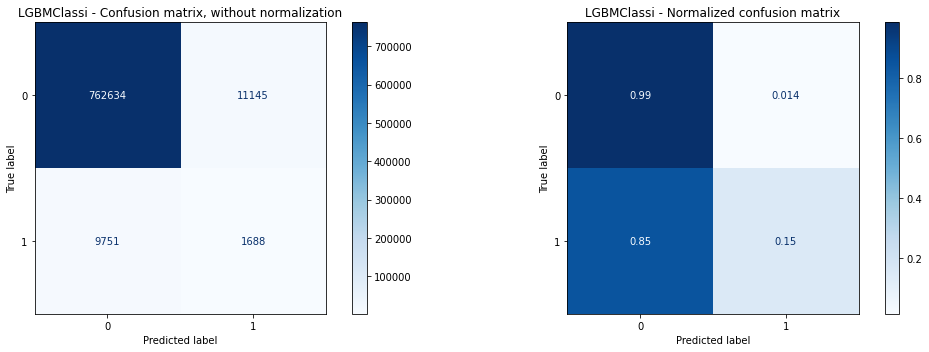

In [9]:
dame_matrices(lgb)

A continuación queremos optimizar la busqueda de los mejores parámetros configurando GridSearchCV para que optimice según la roc_auc más alta para intentar mejorar la tasa de true positives y reducir la de false positives . Para ello, definiremos la metrica que queremos usar añadiendo en los parámetros del GridSearchCV scoring='roc_auc:

### Añadiendo distintos parámetros y pesos para indicar la importancia de las clases en la búsqueda de hiperparámetros

In [6]:
###Busqueda de parametros
gridParams = {
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'class_weight': [{0: 0.1, 1:0.9}, {0: 0.2, 1:0.8}], #aqui le digo que compruebe con dos diferentes pesos para las clases
    'num_leaves': [31, 50]
    }

grid = GridSearchCV(lgb, gridParams, verbose=1, cv=4, n_jobs=-1, scoring="roc_auc")
# Run the grid
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
{'class_weight': {0: 0.2, 1: 0.8}, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 50}
0.9639466698590293


In [7]:
predictions1=grid.predict(X_test)

In [11]:
#Nos guardamos el modelo final entrenado
with open("../models/model_lgb_final.pckl", "wb") as f:
        pickle.dump(grid, f)

### Métricas tras la búsqueda de los mejores hiperparámetros

In [8]:
lgb_pred_proba1 = grid.predict_proba(X_test)
evaluate_model(y_test, predictions1, lgb_pred_proba1)

ROC-AUC score of the model: 0.813909940707218
Accuracy of the model: 0.9744847927581894

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.14      0.15      0.15     11439

    accuracy                           0.97    785218
   macro avg       0.56      0.57      0.57    785218
weighted avg       0.98      0.97      0.97    785218


Confusion matrix: 
[[763480  10299]
 [  9736   1703]]



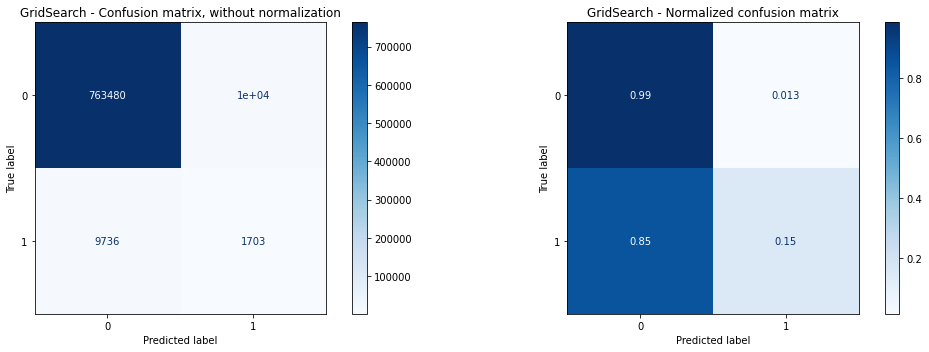

In [10]:
dame_matrices(grid)

Tras la ejecución comprobamos en la matriz de confusión que el modelo nos predice ahora muy ligeramente más unos que antes (probabilidad de involucrarse en un accidente con fallecidos). Sin embargo, este dato no es apreciable en la matriz de confusión normalizada donde el modelo todavía no es capaz de mejorar los porcentajes de true positives con respecto al modelo sin optimizar.

### Visualizacion de las métricas

Primero encontramos el punto (threshold) de corte cuando la probabilidad de predecir maximice el F1. 

A continuación este punto se ve representado sobre el grafico de la curva ROC. 

Después usamos ese punto de corte para mejorar el true positive rate y el false positive rate que correspondería a ese threshold.

Cuanto más cerca el punto negro de la curva ROC se acerque a la esquina superior izquierda (cuanto menos se acerque a la linea azul) signfica que el modelo es mejor, porque tendría un mayor porcentaje de verdaderos positivos por un menor porcentaje de falsos positivos.

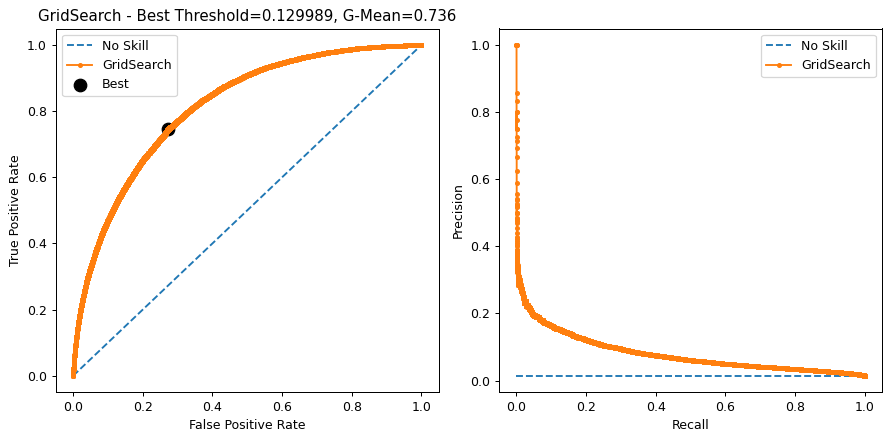

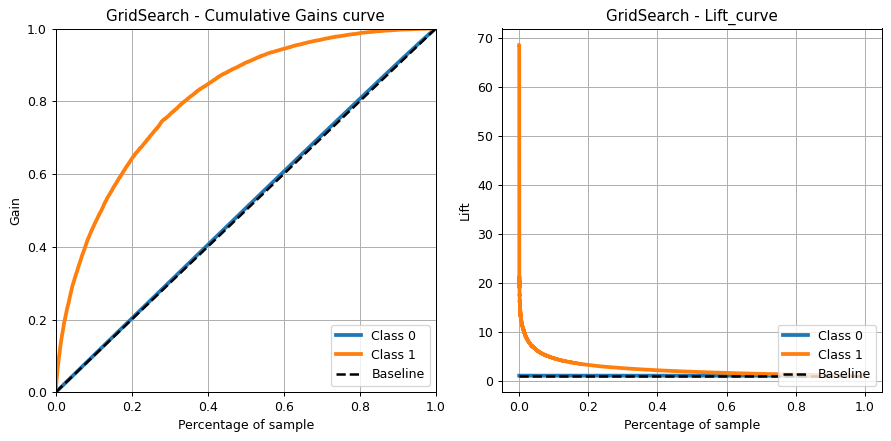

In [12]:
dame_curvas(grid)

### Matrices con threshold ajustado

A continuación configuraremos el modelo para que prediga más unos aunque haya más clasificaciones erróneas moviendo el threshold hacia el punto donde el area por de bajo de la curva ROC es maximizada.

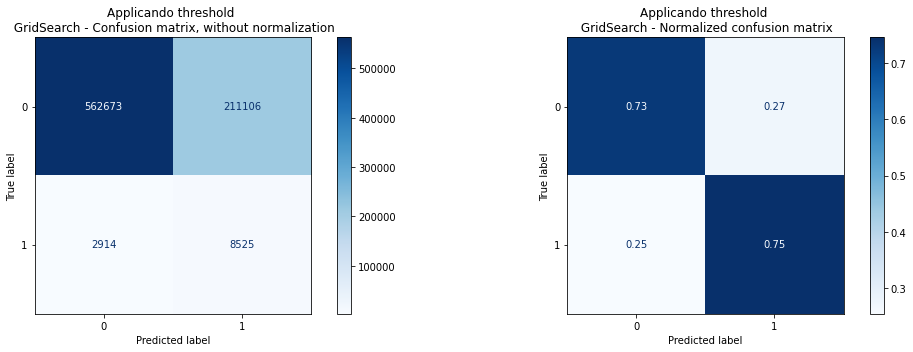

In [13]:
matrices_threshold(grid)

Dependiendo de la matriz de coste proporcionada por la empresa, éste procedimiento tendría un coste más elevado para la empresa pero si queremos que el modelo capture al mayor número de conductores que estarían involucrados en un accidente mortal tiene que ser de esta manera, permitiendo así a las empresas aseguradoras alocar reservas suficientes y nunca por debajo en caso de posibles indemnizaciones.

### Métricas antes y despues de ajustar el threshold

In [16]:
predict_p = grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predict_p)
gmeans = np.sqrt(tpr*(1-fpr))
index = np.argmax(gmeans)
#predictions and optimal thresholds
y_pred = np.where(predict_p>thresholds[index], 1 ,0)

In [23]:
#Métrica antes de aplicar el threshold
evaluate_model(y_test, predictions1, lgb_pred_proba1)

ROC-AUC score of the model: 0.813909940707218
Accuracy of the model: 0.9744847927581894

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.14      0.15      0.15     11439

    accuracy                           0.97    785218
   macro avg       0.56      0.57      0.57    785218
weighted avg       0.98      0.97      0.97    785218


Confusion matrix: 
[[763480  10299]
 [  9736   1703]]



In [24]:
#Métrica después de aplicar el threshold
evaluate_model(y_test, y_pred, lgb_pred_proba1)

ROC-AUC score of the model: 0.813909940707218
Accuracy of the model: 0.7274387494937712

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.73      0.84    773779
           1       0.04      0.75      0.07     11439

    accuracy                           0.73    785218
   macro avg       0.52      0.74      0.46    785218
weighted avg       0.98      0.73      0.83    785218


Confusion matrix: 
[[562673 211106]
 [  2914   8525]]



Como se puede observar, con el ajuste del threshold, se pierce ligeramente precisión y la f1-score global baja pero somos capaces de capturar un mayor número de verdaderos positivos garantizando la reserva de fondos en casos de indemnización por posibles fallecimientos.